# Bert for Sentence Classification - Experimento
## Classificador de tickets do Jira

Este é um componente que utiliza a biblioteca [auto-sklearn](https://github.com/automl/auto-sklearn) para obter um ou mais modelos classificadores já otimizados. <br>
O auto-sklearn é um kit de ferramentas de machine learning automatizado e um substituto para [estimator](https://scikit-learn.org/stable/glossary.html#term-estimators) do [scikit-learn](https://scikit-learn.org/stable/).

Este notebook apresenta:
- como usar o [SDK](https://platiagro.github.io/sdk/) para carregar datasets, salvar modelos e outros artefatos.
- como declarar parâmetros e usá-los para criar componentes reutilizáveis.

## Declaração de parâmetros e hiperparâmetros

Declare parâmetros com o botão  na barra de ferramentas.<br>
O parâmetro `dataset` identifica os conjuntos de dados. Você pode importar arquivos de dataset com o botão  na barra de ferramentas.

In [41]:
# parameters
dataset = "jira-2.csv" #@param {type:"string"}
target = "issuetype" #@param {type:"feature", label:"Atributo alvo", description:"Seu modelo será treinado para prever os valores do alvo."}
text = "description" #@param {type:"string"}

# selected features to perform the model
filter_type = "incluir" #@param ["incluir","remover"] {type:"string",multiple:false,label:"Modo de seleção das features",description:"Se deseja informar quais features deseja incluir no modelo, selecione a opção 'incluir'. Caso deseje informar as features que não devem ser utilizadas, selecione 'remover'. "}
model_features = ["text"] #@param {type:"feature",multiple:true,label:"Features para incluir/remover no modelo",description:"Seu modelo será feito considerando apenas as features selecionadas. Caso nada seja especificado, todas as features serão utilizadas"}

# features to apply One Hot Encoder
one_hot_features = "" #@param {type:"feature", multiple:true, label:"Features para fazer codificação one-hot", description:"Seu modelo utilizará a codificação one-hot para as features selecionadas. As demais features categóricas serão codificadas utilizando a codificação ordinal."}

# hyperparameters
time_left_for_this_task = 60 #@param {type:"integer", label:"Tempo máximo de busca", description:"Limite de tempo (em segundos) para a procura de modelos apropriados."}
per_run_time_limit = 60 #@param {type:"integer", label:"Tempo máximo para ajuste de modelo", description:"Limite de tempo (em segundos), para uma única chamada, para ajuste de um modelo de Machine Learning."}
ensemble_size = 50 #@param {type:"integer", label:"Ensemble Learning", description:"Número de modelos adicionados ao conjunto criado pela seleção do Ensemble das bibliotecas de modelos."}
model_name = 'neuralmind/bert-base-portuguese-cased'  #@param ["bert-base-uncased", "roberta-base","neuralmind/bert-base-portuguese-cased"] {type:"string"}
batch_size =  4#@param {type:"integer"}
max_epochs = 3 #@param {type:"integer"}
accumulate_grad_batches = 16  #@param {type:"integer"}
max_length = 512  #@param {type:"integer"}
learning_rate = 2e-5  #@param {type:"number"}
seed = 7  #@param {type:"integer"}

# predict method
method = "predict_proba" #@param ["predict_proba", "predict"] {type:"string", label:"Método de Predição", description:"Se optar por 'predict_proba', o método de predição será a probabilidade estimada de cada classe, já o 'predict' prediz a qual classe pertence."} 

## Instalaçao dos pacotes externos

In [11]:
! pip install ftfy --quiet

## Preparatiovos para Modelos de NLP

Definindo GPU como padrão e verificando status de hardware

In [12]:
from multiprocessing import cpu_count
import torch
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)
if dev == "cpu":
    print(f"number of CPU cores: {cpu_count()}")
else:
    print(f"GPU: {torch.cuda.get_device_name(0)}, number of CPU cores: {cpu_count()}")

number of CPU cores: 4


Instanciando Tokenizador

In [4]:
from transformers import BertModel,BertForSequenceClassification, BertTokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)
hyperparms = {'model_name':model_name,'tokenizer':tokenizer,'learning_rate':learning_rate,'batch_size':batch_size,'max_epochs':max_epochs,'accumulate_grad_batches':accumulate_grad_batches,'max_length':max_length} 

Impedir Excesso de logs nos modelos de NLP

In [5]:
import logging
logging.getLogger("transformers.configuration_utils").setLevel(logging.WARNING)
logging.getLogger("transformers.modeling_utils").setLevel(logging.WARNING)
logging.getLogger("lightning").setLevel(logging.WARNING)

Fixar semente de pesos aleatporios para replicabilidade

In [6]:
import random
random.seed(seed)
torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)

Decorator que auxilia para impedir quebra de memoria

In [7]:
import functools
import traceback
import psutil
def gpu_mem_restore(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

Incluindo informações adicionais na barra de carregamento dos modelos do Pytorch Lightning

## Acesso ao conjunto de dados

O conjunto de dados utilizado nesta etapa será o mesmo carregado através da plataforma.<br>
O tipo da variável retornada depende do arquivo de origem:
- [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) para CSV e compressed CSV: .csv .csv.zip .csv.gz .csv.bz2 .csv.xz
- [Binary IO stream](https://docs.python.org/3/library/io.html#binary-i-o) para outros tipos de arquivo: .jpg .wav .zip .h5 .parquet etc

In [13]:
import pandas as pd

df = pd.read_csv(f'/tmp/data/{dataset}')
df.head()

,HD_ID,issuetype,summary,components,description,Unnamed: 5
0,HD-82125,Requisição,Jira e confluence não acessar sem VPN e VPN do...,VPN,Jira e confluence não acessar sem VPN e VPN do...,NaN
1,HD-82111,Requisição,DT para levar monitor de computador DELL para ...,Partes/peças,"Boa tarde, tudo bem?\n\nGostaria de solicitar,...",NaN
2,HD-82104,Requisição,Acesso ao Novo SVN,Jira,"Gustavo, boa tarde!\n\nPor gentileza, adiciona...",NaN
3,HD-82097,Requisição,Instalação de softwares - Troca de máquina,Software Windows,"Devido ao trabalho remoto, está inviável traba...",NaN
4,HD-82092,Incidente,Solicitação de perfil de administrador via aut...,Autoatendimento,Estou conectado na nova VPN do CPQD (via Forti...,NaN


## Trabalhando os dados

Removendo as classes desnecessárias

In [14]:
df = df[[text, target]]
df = df.rename(columns={text: "text", target: "target"})
text, target = "text","target"
df = df[(df.target != 'Epic') & (df.target != 'Demanda') & (df.target != 'Bug') & (df.target != 'Sub-task')]

## Acesso aos metadados do conjunto de dados

Utiliza a função `stat_dataset` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para carregar metadados. <br>
Por exemplo, arquivos CSV possuem `metadata['featuretypes']` para cada coluna no conjunto de dados (ex: categorical, numerical, or datetime).

In [15]:
import numpy as np
from platiagro import stat_dataset
from platiagro import save_dataset

save_dataset(name=dataset, df=df)
metadata = stat_dataset(name=dataset)
featuretypes = metadata["featuretypes"]
columns = df.columns.to_numpy()
featuretypes = np.array(featuretypes)
target_index = np.argwhere(columns == target)
columns = np.delete(columns, target_index)
featuretypes = np.delete(featuretypes, target_index)

## Remoção de linhas com valores faltantes no atributo alvo

Filtragem de elementos do texto

In [16]:
import re
def text_filter(original_cell):
    cell = re.sub('{.*?}', ' ', original_cell) #Remoção das tags de color:{#000000}
    cell = re.sub('<.*?>', ' ', cell) #Remoção das tags de espaço ou qualquer outra que aparecer
    cell = re.sub(r'http\S+', '', cell) #Remoção de endereços web
    cell = re.sub("/\r\n|\n|\r|", "",cell);#Remoção de line breaks por \n e \r
    cell = re.sub(' +', ' ',cell) #Transformação de multiplos espaços em um único espaço
    return cell

Caso haja linhas em que o atributo alvo contenha valores faltantes, é feita a remoção dos casos faltantes.

In [17]:
#df.dropna(subset = [target],inplace=True)
df=df.dropna()
df[text] = df[text].apply(lambda x: text_filter(x))
y = df[target].to_numpy()

## Filtragem das features 

Seleciona apenas as features que foram declaradas no parâmetro model_features. Se nenhuma feature for especificada, todo o conjunto de dados será utilizado para a modelagem.

In [18]:
if filter_type == 'incluir':
    if len(model_features) >= 1:
        columns_index = (np.where(np.isin(columns,model_features)))[0]
        columns_index.sort()
        columns_to_filter = columns[columns_index]
        featuretypes = featuretypes[columns_index]
    else:
        columns_to_filter = columns
else:
    if len(model_features) >= 1:
        columns_index = (np.where(np.isin(columns,model_features)))[0]
        columns_index.sort()
        columns_to_filter = np.delete(columns,columns_index)
        featuretypes = np.delete(featuretypes,columns_index)
    else:
        columns_to_filter = columns

# keep the features selected
df_model = df[columns_to_filter]
X = df_model.to_numpy()

## Codifica labels do atributo alvo

As labels do atributo alvo são convertidos em números inteiros ordinais com valor entre 0 e n_classes-1.

In [19]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [20]:
y

array([1, 1, 1, ..., 1, 0, 1])

## Divide dataset em subconjuntos de treino e teste

Subconjunto de treino: amostra de dados usada para treinar o modelo.<br>
Subconjunto de teste: amostra de dados usada para fornecer uma avaliação imparcial do treinamento do modelo no subconjunto de dados de treino.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,  train_size=0.9,random_state=42,stratify = y)

## Configuração das features

In [22]:
from platiagro.featuretypes import NUMERICAL

# Selects the indexes of numerical and non-numerical features
numerical_indexes = np.where(featuretypes == NUMERICAL)[0]
non_numerical_indexes = np.where(~(featuretypes == NUMERICAL))[0]

# Selects non-numerical features to apply ordinal encoder or one-hot encoder
one_hot_features = np.asarray(one_hot_features)
non_numerical_indexes_one_hot = np.where(~(featuretypes == NUMERICAL) & np.isin(columns_to_filter,one_hot_features))[0]
non_numerical_indexes_ordinal = np.where(~(featuretypes == NUMERICAL) & ~(np.isin(columns_to_filter,one_hot_features)))[0]

# After the step handle_missing_values, 
# numerical features are grouped in the beggining of the array
numerical_indexes_after_handle_missing_values = \
    np.arange(len(numerical_indexes))
non_numerical_indexes_after_handle_missing_values = \
    np.arange(len(numerical_indexes), len(featuretypes))
one_hot_indexes_after_handle_missing_values = non_numerical_indexes_after_handle_missing_values[np.where(np.isin(non_numerical_indexes,non_numerical_indexes_one_hot))[0]]         
ordinal_indexes_after_handle_missing_values = non_numerical_indexes_after_handle_missing_values[np.where(np.isin(non_numerical_indexes,non_numerical_indexes_ordinal))[0]]                                              

## Classe de Dataset

In [23]:
from typing import List
import ftfy
from torch.utils.data import Dataset



class MyDataset(Dataset):
    def __init__(self, texts: List[str],target: List[int],tokenizer,max_length):
        self.texts = texts
        self.target =  torch.tensor(target).type(torch.long)
        self.tokenizer = tokenizer
        self.max_length = max_length

        
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        encoder_plus = self.encoder_plus(ftfy.fix_text(text[0]))
        token_ids = encoder_plus['input_ids']
        attention_mask = encoder_plus['attention_mask']
        token_type_ids = encoder_plus['token_type_ids']
        #tranformacao para tensor
        token_ids = torch.tensor(token_ids).type(torch.long)
        attention_mask = torch.tensor(attention_mask).type(torch.long)
        token_type_ids = torch.tensor(token_type_ids).type(torch.long)

        return token_ids, attention_mask, token_type_ids, self.target[idx]
  
    #already truncate and paded
    def encoder_plus(self,text):
        return self.tokenizer.encode_plus(text,
                                  max_length = self.max_length,
                                  pad_to_max_length=True,
                                  truncation = True)

Testando o Dataloader

In [24]:
from torch.utils.data import DataLoader

X_debug = X_train[:10]
y_debug = y_train[:10]

print(X_debug[0])
print(y_debug[0])
print(type(X_debug))
print(type(y_debug))
print(50*'-')

dataset_debug = MyDataset(
    texts=X_debug,
    target=y_debug,
    tokenizer=tokenizer,
    max_length=max_length)


dataloader_debug = DataLoader(dataset_debug, batch_size=batch_size, shuffle=True, num_workers=cpu_count())
token_ids, attention_mask, token_type_ids, target = next(iter(dataloader_debug))

print('token_ids:\n', token_ids)
print('token_type_ids:\n', token_type_ids)
print('attention_mask:\n', attention_mask)
print('target:\n', target)

print('token_ids.shape:', token_ids.shape)
print('token_type_ids.shape:', token_type_ids.shape)
print('attention_mask.shape:', attention_mask.shape)
print('target.shape:', target.shape)

['Aumentar tablespace dos bancos SAFRMIG7_SCH e SAF*_MIG4.Ao tentar criar a partição no banco SAFRMIG7_SCH, foi apresentado um erro informando que não era possível estender a tabela sys.indpart. Vide evidência em anexo.Solicito que o tamanho da tablespace seja expandido tanto para o banco SAFRMIG7_SCH quanto para os do SAF*_MIG4.Usuário: SAFRMIG7_SCHHost: vmbd7.cpqd.com.brPorta: 1521Nome do serviço: bd710i1Usuário: SAF*_MIG4Host: vmbd50.cpqd.com.brPorta: 1521Nome do serviço: bd511i3Obs.: O Aijalom Correa já está ciente do problema. Favor, encaminhar ao mesmo.']
1
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
--------------------------------------------------
token_ids:
 tensor([[  101,   115,   115,  ...,     0,     0,     0],
        [  101,  8399,   644,  ...,     0,     0,     0],
        [  101,  4407, 16682,  ...,     0,     0,     0],
        [  101,  7723,  1373,  ...,     0,     0,     0]])
token_type_ids:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
 

## Classe que define o modelo do pytorch lightning

In [25]:
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import accuracy_score
import pytorch_lightning as pl

class BertFinetuner(pl.LightningModule):

    def __init__(self, 
                 hyperparms,
                 all_data,
                 criterion = torch.nn.CrossEntropyLoss(),
                 overfit=False,
                 sampler = False):
      

        super(BertFinetuner, self).__init__()
        self.model = BertModel.from_pretrained(hyperparms['model_name'])
        self.predict_proba  =  torch.nn.Softmax(dim=1)
        #---------- Hyperparametros
        
        self.tokenizer = hyperparms['tokenizer']
        self.learning_rate = hyperparms['learning_rate']
        self.batch_size = hyperparms['batch_size']
        self.max_length = hyperparms['max_length']
        self.overfit = overfit
        self.training = False

        #---------- Carregamento datasets (Para eu poder variar self.max_length)
        self.sampler = sampler
        self.targets_sampler = all_data[1]
        if overfit:
            self.train_dataset = MyDataset(all_data[0], all_data[1],self.tokenizer,self.max_length)
            self.test_dataset =   MyDataset(all_data[0], all_data[1],self.tokenizer,self.max_length)
        else:
            self.train_dataset = MyDataset(all_data[0], all_data[1],self.tokenizer,self.max_length)
            self.test_dataset = MyDataset(all_data[2], all_data[3],self.tokenizer,self.max_length)
        
        
        #---------- Loss Function
        self.loss_funtion = criterion

        #---------- Datafame de comparação para o teste
        self.df_test = pd.DataFrame(columns=['ORIGINAL_TARGET','ORIGINAL_CODE','PREDICTED_TARGET','PREDICTED_CODE','INC_PROBA','REQ_PROBA'])
        
        self.classification_specific = False


        #---------- Englobamentoda rede para classificação(se necessário)
        if self.classification_specific:
            pass
        else:
            self.num_classes = 2
            self.classification_layer = torch.nn.Linear(self.model.config.hidden_size, self.num_classes)
        
    def infer(self,ticket):
        tok = self.tokenizer.encode_plus(ticket, return_tensors='pt')
        logits = self.forward(tok['input_ids'].to(device), tok['attention_mask'].to(device),tok['token_type_ids'].to(device))
        _, predicted_codes = torch.max(logits, dim=1)
        return label_encoder.inverse_transform(predicted_codes.data.cpu().numpy())

    def infer_probablities(self,ticket):
        tok = self.tokenizer.encode_plus(ticket, return_tensors='pt')
        logits = self.forward(tok['input_ids'].to(device), tok['attention_mask'].to(device),tok['token_type_ids'].to(device))
        return self.predict_proba(logits).data.cpu().numpy()

    def forward(self, token_ids, attention_mask, token_type_ids=None, original_codes=None):

        if self.classification_specific:
            outputs = self.model(token_ids,labels=original_codes,attention_mask=attention_mask, token_type_ids=token_type_ids)
            logits = outputs[1]
        else:
            outputs = self.model(token_ids,attention_mask=attention_mask, token_type_ids=token_type_ids)
            hidden_states = outputs[0]
            cls_vector = hidden_states[:, 0, :]
            logits = self.classification_layer(cls_vector)
        return logits


    def training_step(self, batch, batch_nb):
        # batch
        token_ids, attention_mask, token_type_ids, original_codes = batch
         
        # fwd
        y_hat = self.forward(token_ids, attention_mask, token_type_ids, original_codes)
        
        # loss
        loss = self.loss_funtion(y_hat, original_codes)
        
        # What to log
        tensorboard_logs = {'loss': loss}

        return {'loss': loss, 'log': tensorboard_logs}


    def test_step(self, batch, batch_nb):
        # batch
        token_ids, attention_mask, token_type_ids, original_codes = batch
         
        # fwd
        y_hat = self.forward(token_ids, attention_mask, token_type_ids, original_codes)
        
        # Calculate acc
        acc = self.get_acc(y_hat, original_codes)

        #constructing dataframe
        _, predicted_codes = torch.max(y_hat, dim=1)
        predicted_targets = label_encoder.inverse_transform(predicted_codes.data.cpu().numpy())
        original_targets = label_encoder.inverse_transform(original_codes.data.cpu().numpy())
        classes_probabilities = self.predict_proba(y_hat).data.cpu().numpy()        
        for original_target,original_code,predicted_target,predicted_code,classes_probability in zip(original_targets,original_codes,predicted_targets,predicted_codes,classes_probabilities):
            self.df_test = self.df_test.append(pd.Series([original_target,int(original_code),predicted_target,int(predicted_code),classes_probability[0],classes_probability[1]], index=self.df_test.columns ), ignore_index=True)
            
        
        return {'test_acc_batch': acc}

    def test_epoch_end(self, outputs):
        if not outputs: return {}

        avg_test_acc = torch.stack([x['test_acc_batch'] for x in outputs]).mean()

        tensorboard_logs = {'avg_test_acc': avg_test_acc}

        return {'avg_test_acc': avg_test_acc, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.Adam(
            [p for p in self.parameters() if p.requires_grad],
            lr=self.learning_rate, eps=1e-08)
    
    def get_acc(self,y_hat,original_codes):
        _, y_hat = torch.max(y_hat, dim=1)
        val_acc = accuracy_score(y_hat.cpu(), original_codes.cpu())
        return torch.tensor(val_acc)
    
    
    #@gpu_mem_restore
    def train_dataloader(self):
        if self.sampler:
          # shuffle = False if self.overfit else True
            targets = []
            for target in self.targets_sampler:
                targets.append(target)
            targets = torch.tensor(targets).type(torch.long)
            # Compute samples weight (each sample should get its own weight)
            class_sample_count = torch.tensor( [(targets == t).sum() for t in torch.unique(targets, sorted=True)])
            weight = 1. / class_sample_count.float()
            samples_weight = torch.tensor([weight[t] for t in targets])

            # Create sampler, dataset, loader
            sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
            shuffle = False
        else:
            shuffle = True
            sampler = None

        return DataLoader(self.train_dataset, sampler = sampler, batch_size=self.batch_size, shuffle=shuffle,num_workers=cpu_count())
    
    
    #@gpu_mem_restore
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,shuffle=False, num_workers=cpu_count())

## Baixando pesos da Cloud

In [26]:
import os
cwd = os.getcwd()
cwd

'/home/jovyan/tasks/Bert_For_Sentiment_Analyses'

In [27]:
! gsutil cp gs://platiagro/Jira_Tickets_Classification/jira_classification_epoch0ckpt.zip  /home/jovyan/tasks/Bert_For_Sentiment_Analyses
! gsutil cp gs://platiagro/Jira_Tickets_Classification/jira_classification_epoch1ckpt.zip  /home/jovyan/tasks/Bert_For_Sentiment_Analyses
! gsutil cp gs://platiagro/Jira_Tickets_Classification/jira_classification_epoch2ckpt.zip  /home/jovyan/tasks/Bert_For_Sentiment_Analyses

Copying gs://platiagro/Jira_Tickets_Classification/jira_classification_epoch0ckpt.zip...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

\ [1 files][  1.0 GiB/  1.0 GiB]  494.7 KiB/s                                   
Operation completed over 1 objects/1.0 GiB.                                      
Copying gs://platiagro/Jira_Tickets_Classification/jira_classification_epoch1ckpt.zip...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

- [1 files][  1.0 GiB/  1.0 GiB]    3.0 MiB/s                                   
Operation completed over 1 objects/1.0 GiB.                     

Extraindo os pesos do arquivo zip

In [28]:
!unzip "/home/jovyan/tasks/Bert_For_Sentiment_Analyses/jira_classification_epoch0ckpt.zip" -d "/home/jovyan/tasks/Bert_For_Sentiment_Analyses/"
!unzip "/home/jovyan/tasks/Bert_For_Sentiment_Analyses/jira_classification_epoch1ckpt.zip" -d "/home/jovyan/tasks/Bert_For_Sentiment_Analyses/"
!unzip "/home/jovyan/tasks/Bert_For_Sentiment_Analyses/jira_classification_epoch2ckpt.zip" -d "/home/jovyan/tasks/Bert_For_Sentiment_Analyses/"

Archive:  /home/jovyan/tasks/Bert_For_Sentiment_Analyses/jira_classification_epoch0ckpt.zip
  inflating: /home/jovyan/tasks/Bert_For_Sentiment_Analyses/epoch=0.ckpt  
Archive:  /home/jovyan/tasks/Bert_For_Sentiment_Analyses/jira_classification_epoch1ckpt.zip
  inflating: /home/jovyan/tasks/Bert_For_Sentiment_Analyses/epoch=1.ckpt  
Archive:  /home/jovyan/tasks/Bert_For_Sentiment_Analyses/jira_classification_epoch2ckpt.zip
  inflating: /home/jovyan/tasks/Bert_For_Sentiment_Analyses/epoch=2.ckpt  


## Treinando o modelo

In [ ]:
#! pip install pytorch-lightning==0.8.4 --quiet

In [29]:
from pytorch_lightning.callbacks import ModelCheckpoint
checkpoint_path = cwd + '/epoch=2.ckpt'
checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))
print(f'Files in {checkpoint_dir}: {os.listdir(checkpoint_dir)}')
print(f'Saving checkpoints to {checkpoint_dir}')
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_dir, save_top_k=-1,mode="max")  # Keeps all checkpoints.
print('Checkpoint Callback: ',checkpoint_callback)

resume_from_checkpoint = None
if os.path.exists(checkpoint_path):
    print(f'Restoring checkpoint: {checkpoint_path}')
    resume_from_checkpoint = checkpoint_path

    
all_data = [X_train, y_train,X_test,y_test]
trainer = pl.Trainer(gpus=0,
                     max_epochs=max_epochs,
                     check_val_every_n_epoch=1,
                     profiler=True,
                     accumulate_grad_batches=accumulate_grad_batches,
                     checkpoint_callback=checkpoint_callback,
                     progress_bar_refresh_rate=10,
                     resume_from_checkpoint=resume_from_checkpoint)

bert = BertFinetuner(all_data=all_data,hyperparms=hyperparms,sampler = True) 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Files in /home/jovyan/tasks/Bert_For_Sentiment_Analyses: ['jira_classification_epoch1ckpt.zip', '.ipynb_checkpoints', 'Experiment.ipynb', 'jira_classification_epoch0ckpt.zip', 'epoch=2.ckpt', 'Deployment.ipynb', 'epoch=1.ckpt', 'epoch=0.ckpt', 'jira_classification_epoch2ckpt.zip']
Saving checkpoints to /home/jovyan/tasks/Bert_For_Sentiment_Analyses
Checkpoint Callback:  <pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f487126a310>
Restoring checkpoint: /home/jovyan/tasks/Bert_For_Sentiment_Analyses/epoch=2.ckpt


In [30]:
trainer.fit(bert)


  | Name                 | Type             | Params
----------------------------------------------------------
0 | model                | BertModel        | 108 M 
1 | predict_proba        | Softmax          | 0     
2 | loss_funtion         | CrossEntropyLoss | 0     
3 | classification_layer | Linear           | 1 K   




Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_train_start      	|  0.040582       	|  0.040582       
on_train_end        	|  0.0015725      	|  0.0015725      



1

In [31]:
trainer.test(bert)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: You're resuming from a checkpoint that ended mid-epoch. This can cause unreliable results if further training is done, consider using an end of epoch checkpoint. 
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_acc': tensor(0.8643, dtype=torch.float64)}
--------------------------------------------------------------------------------



In [32]:
bert.df_test.head()

,ORIGINAL_TARGET,ORIGINAL_CODE,PREDICTED_TARGET,PREDICTED_CODE,INC_PROBA,REQ_PROBA
0,Requisição,1,Requisição,1,0.006076,0.993924
1,Requisição,1,Requisição,1,0.001356,0.998644
2,Incidente,0,Incidente,0,0.953932,0.046068
3,Requisição,1,Requisição,1,0.007231,0.992769
4,Incidente,0,Incidente,0,0.965567,0.034433


## Visualização de desempenho

A [**Matriz de Confusão**](https://en.wikipedia.org/wiki/Confusion_matrix) (Confusion Matrix) é uma tabela que nos permite a visualização do desempenho de um algoritmo de classificação. <br>
É extremamente útil para mensurar [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification), [Recall, Precision, and F-measure](https://en.wikipedia.org/wiki/Precision_and_recall).

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

# uses the model to make predictions on the Test Dataset
y_pred = list(bert.df_test['PREDICTED_CODE']) 
y_prob =  [[a,b] for a,b in zip(list(bert.df_test['INC_PROBA']),list(bert.df_test['REQ_PROBA']))]

# computes confusion matrix
labels = np.unique(y)
data = confusion_matrix(y_test, y_pred, labels=labels)

# computes precision, recall, f1-score, support (for multiclass classification problem) and accuracy
if len(labels) > 2:
    # multiclass classification
    p, r, f1, s = precision_recall_fscore_support(y_test, y_pred,
                                                  labels=labels,
                                                  average=None)
    
    commom_metrics = pd.DataFrame(data=zip(p, r, f1, s),columns=['Precision','Recall','F1-Score','Support']) 
    
    average_options = ('micro', 'macro', 'weighted')
    for average in average_options:
        if average.startswith('micro'):
            line_heading = 'accuracy'
        else:
            line_heading = average + ' avg'

        # compute averages with specified averaging method
        avg_p, avg_r, avg_f1, _ = precision_recall_fscore_support(
            y_test, y_pred, labels=labels,
            average=average)
        avg = pd.Series({'Precision':avg_p,  'Recall':avg_r,  'F1-Score':avg_f1,  'Support':np.sum(s)},name=line_heading)
        commom_metrics = commom_metrics.append(avg)
else:
    # binary classification
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred,
                                                  average='binary')
    accuracy=accuracy_score(y_test, y_pred)
    commom_metrics = pd.DataFrame(data={'Precision':p,'Recall':r,'F1-Score':f1,'Accuracy':accuracy},index=[1])

# puts matrix in pandas.DataFrame for better format
labels = label_encoder.inverse_transform(labels)
confusion_matrix = pd.DataFrame(data, columns=labels, index=labels)

# add correct index labels to commom_metrics DataFrame (for multiclass classification)
if len(labels)>2:
    as_list = commom_metrics.index.tolist()
    as_list[0:len(labels)] = labels
    commom_metrics.index = as_list

## Salva métricas

Utiliza a função `save_metrics` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para salvar métricas. Por exemplo: `accuracy`, `precision`, `r2_score`, `custom_score` etc.<br>

In [34]:
from platiagro import save_metrics

save_metrics(confusion_matrix=confusion_matrix,commom_metrics=commom_metrics)

<Figure size 432x288 with 0 Axes>

## Salva figuras

Utiliza a função `save_figures` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para salvar figuras do [matplotlib](https://matplotlib.org/3.2.1/gallery/index.html). <br>

A avaliação do desempenho do modelo pode ser feita por meio da análise da [Curva ROC (ROC)](https://pt.wikipedia.org/wiki/Caracter%C3%ADstica_de_Opera%C3%A7%C3%A3o_do_Receptor).  Esse gráfico permite avaliar a performance de um classificador binário para diferentes pontos de cortes. A métrica [AUC (Area under curve)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) também é calculada e indicada na legenda do gráfico.<br>
Se a variável resposta tiver mais de duas categorias, o cálculo da curva ROC e AUC é feito utilizando o algoritmo [one-vs-rest](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics), ou seja, calcula-se a curva ROC e AUC de cada classe em relação ao restante.

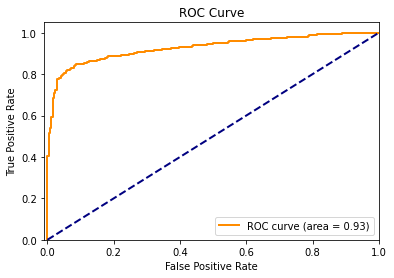

In [35]:
from matplotlib.pyplot import cm
from platiagro import save_figure
from platiagro import list_figures
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
import matplotlib.pyplot as plt

y_pred = list(bert.df_test['PREDICTED_CODE']) 
y_prob =  [[a,b] for a,b in zip(list(bert.df_test['INC_PROBA']),list(bert.df_test['REQ_PROBA']))]

def plot_roc_curve(y_test,y_prob,labels):
    n_classes = len(labels)
    y_test = list(y_test)
    y_prob=np.array(y_prob)

    if n_classes == 2:
        # Compute ROC curve 
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)  
        
        # Plot ROC Curve
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([-0.01, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        save_figure(figure=plt.gcf())
        plt.show()
        
    else:  
        # Binarize the output
        lb = preprocessing.LabelBinarizer()
        y_test_bin = lb.fit_transform(y_test)

        # Compute ROC curve for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()  

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        color=cm.rainbow(np.linspace(0,1,n_classes+1))
        plt.figure()
        lw = 2
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([-0.01, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
        for i,c in zip(range(n_classes),color):                   
            plt.plot(fpr[i], tpr[i], color=c,
             lw=lw, label='ROC curve - Class %s (area = %0.2f)' % (labels[i] ,roc_auc[i]))
            plt.title('ROC Curve One-vs-Rest')
            plt.legend(loc="lower right")
        
        save_figure(figure=plt.gcf())
        plt.show()

plot_roc_curve(y_test,y_prob,labels)

## Salva alterações no conjunto de dados

O conjunto de dados será salvo (e sobrescrito com as respectivas mudanças) localmente, no container da experimentação, utilizando a função `pandas.DataFrame.to_csv`.<br>

In [36]:
from re import sub

new_columns = np.array(bert.df_test.columns)
df_test_x = pd.DataFrame(X_test,columns=['text'])
result_dataframe = pd.concat([df_test_x, bert.df_test], axis=1, sort=False)

# save dataset changes
bert.df_test.to_csv(f'/tmp/data/{dataset}', index=False)

## Salva modelo e outros artefatos

Utiliza a função `save_model` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para salvar modelos e outros artefatos.<br>
Essa função torna estes artefatos disponíveis para o notebook de implantação.

In [37]:
from platiagro import save_model

save_model(columns=columns,
           label_encoder=label_encoder,
           model=bert,
           method=method,
           new_columns=new_columns)

/opt/conda/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


TypeError: can't pickle tensorflow.python._pywrap_file_io.WritableFile objects